<a href="https://colab.research.google.com/github/Sunnnyyy16/Dacon_study/blob/main/bike/seoul_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 서울시 따릉이 대여량 예측 경진대회
사이트: https://dacon.io/competitions/open/235576/overview/description

# 목차
1. 데이터 EDA
2. 데이터 전처리
3. 모델링
4. 결론

참고

https://dacon.io/competitions/open/235576/codeshare/617?page=1&dtype=recent

https://velog.io/@dohy426/LGBM-Regressor-Optuna

https://dacon.io/competitions/official/235837/codeshare/3724?page=1&dtype=recent

https://dacon.io/competitions/official/235837/codeshare/3687?page=1&dtype=recent

# 데이터 로드

서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
!cp /gdrive/MyDrive/Dacon_study/bike/submission.csv ./
!cp /gdrive/MyDrive/Dacon_study/bike/test.csv ./
!cp /gdrive/MyDrive/Dacon_study/bike/train.csv ./

In [38]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [5]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


* id : 고유 id
* hour : 시간
* hour_bef_temperature : 기온
* hour_bef_precipitation : 비 오지 않았으면 0, 비 오면 1
* hour_bef_windspeed : 풍속(평균)
* hour_bef_humidity : 습도
* hour_bef_visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* hour_bef_ozone : 오존
* hour_bef_pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* hour_bef_pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수

In [ ]:
train['hour'].value_counts()

20    61
4     61
5     61
11    61
22    61
19    61
15    61
7     61
8     61
10    61
1     61
14    61
9     61
3     61
2     61
18    61
23    61
6     61
12    61
13    60
17    60
16    60
0     60
21    60
Name: hour, dtype: int64

날짜가 없고 시간만 있어서 정확한 EDA 및 분석이 어려울 것 같다.

## null값 확인

In [ ]:
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

null값 존재 --> 처리 필요

In [ ]:
test.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

null값 존재 --> 처리 필요

## null값 처리

In [39]:
train['hour_bef_temperature'] =train['hour_bef_temperature'].fillna(value=train['hour_bef_temperature'].mean())
train['hour_bef_precipitation'] =train['hour_bef_precipitation'].fillna(0)
train['hour_bef_windspeed'] =train['hour_bef_windspeed'].fillna(value=train['hour_bef_windspeed'].mean())
train['hour_bef_humidity'] =train['hour_bef_humidity'].fillna(value=train['hour_bef_humidity'].mean())
train['hour_bef_visibility'] =train['hour_bef_visibility'].fillna(value=train['hour_bef_visibility'].mean())
train['hour_bef_ozone'] =train['hour_bef_ozone'].fillna(value=train['hour_bef_ozone'].mean())
train['hour_bef_pm10'] =train['hour_bef_pm10'].fillna(value=train['hour_bef_pm10'].mean())
train['hour_bef_pm2.5'] =train['hour_bef_pm2.5'].fillna(value=train['hour_bef_pm2.5'].mean())

# 01.데이터 EDA

In [ ]:
# 시간대별 자전거 대여량
train.groupby(['hour'])['count'].mean().to_frame().reset_index()

,hour,count
0,0,71.766667
1,1,47.606557
2,2,31.409836
3,3,21.377049
4,4,13.524590
5,5,13.114754
6,6,24.557377
7,7,62.360656
8,8,136.688525
9,9,93.540984


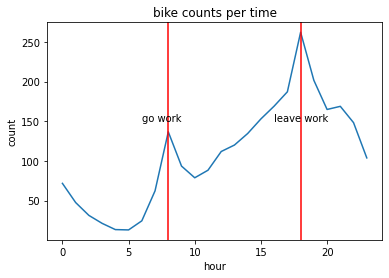

In [ ]:
plt.figure()
sns.lineplot(x='hour', y='count', data=train.groupby(['hour'])['count'].mean().to_frame().reset_index())
plt.axvline(x=8,color='r')
plt.axvline(x=18,color='r')
plt.text(6,150, 'go work')
plt.text(16,150, 'leave work')
plt.title('bike counts per time')
plt.show()

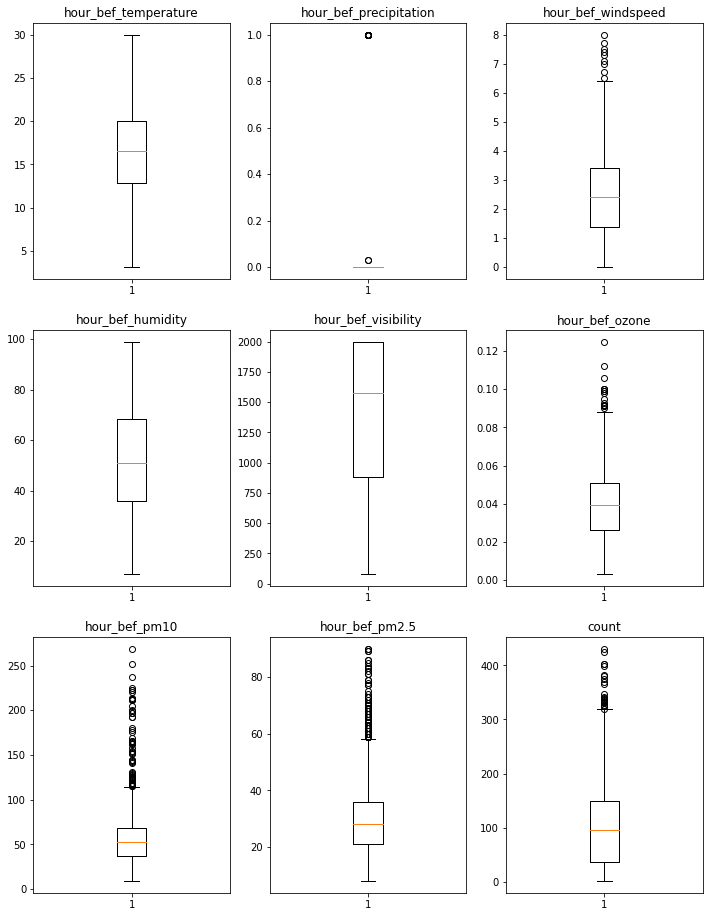

In [ ]:
# boxplot으로 데이터 분포 확인
plt.figure(figsize=(12,16))

cols= train.columns[2:]
for i in range(len(cols)):
  plt.subplot(3,3, i+1)
  plt.title(cols[i])
  plt.boxplot(train[cols[i]])
plt.show()

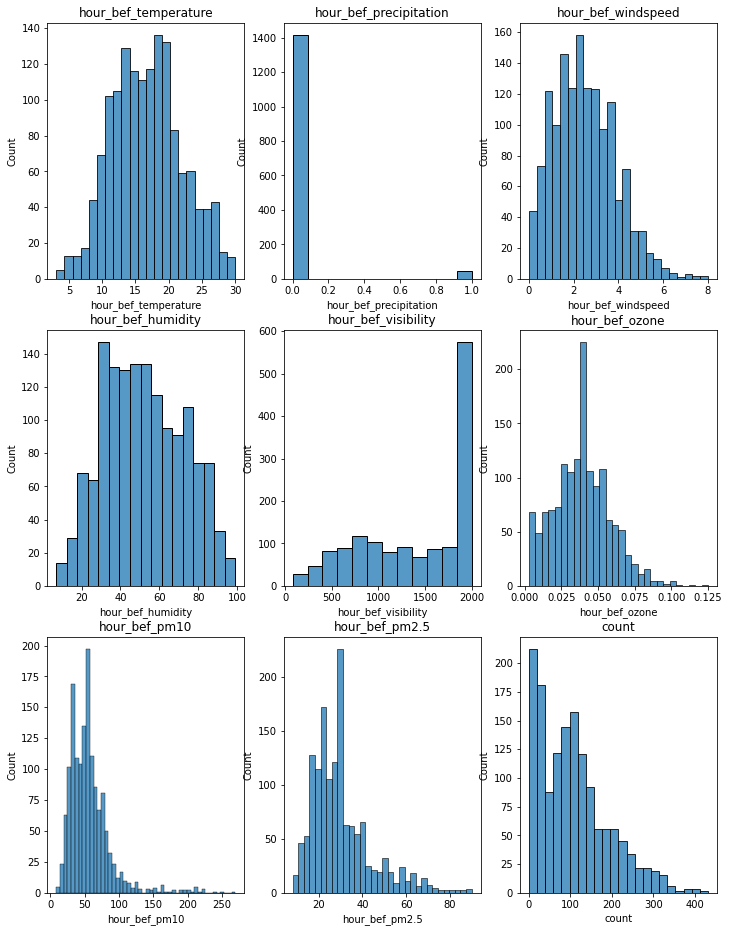

In [ ]:
# histplot으로 데이터 분포 확인
plt.figure(figsize=(12,16))

cols= train.columns[2:]
for i in range(len(cols)):
  plt.subplot(3,3, i+1)
  plt.title(cols[i])
  sns.histplot(train[cols[i]])
plt.show()

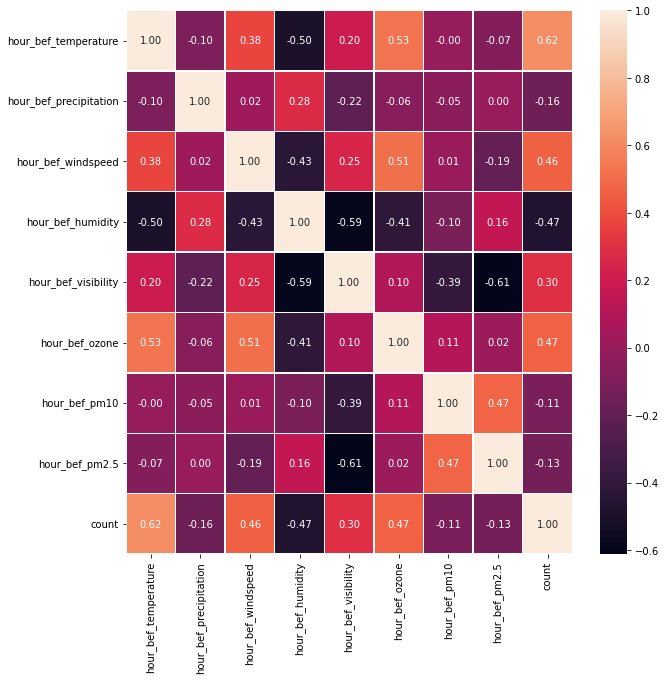

In [ ]:
train_corr=train.drop(['id','hour'], axis=1)

plt.figure(figsize=(10,10))
sns.heatmap(data = train_corr.corr(), annot=True, fmt = '.2f', linewidths=.5)

hour_bef_precipitation은 count에 큰 영향을 주지 않는 것 같다. 

hour_bef_precipitation : 비 오지 않았으면 0, 비 오면 1

비가 와도 아주 조금 오면 따릉이 탈 수도 있음. 강수량이 중요하지 강수유무는 안 중요할 수도

# 02.데이터 전처리

## Feature Engineering

feature selection, 이미 있는 feature로 새로운 feature 만들기

**불쾌지수 feature**

In [7]:
# 불쾌지수 함수 만들기
def get_discomfort(humidity,temperature):
  discomfort = 0.4*(humidity+temperature) +4.8
  
  return discomfort

In [40]:
# 불쾌지수 함수로 새 컬럼 만들기
train['discomfort'] = [0]* len(train)

for i in range(len(train)):
  train.discomfort[i] = get_discomfort(train.hour_bef_humidity[i],train.hour_bef_temperature[i])

test['discomfort'] = [0] * len(test)
for i in range(len(test)):
  test.discomfort[i] = get_discomfort(test.hour_bef_humidity[i],test.hour_bef_temperature[i])

**hardship 피쳐 추가**

In [41]:
train['hardship'] = train['hour_bef_visibility']* train['hour_bef_windspeed']
test['hardship'] = test['hour_bef_visibility']* test['hour_bef_windspeed']

In [42]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,discomfort,hardship
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,46,864.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,32,1282.4
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,41,967.4
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,29,2554.2
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,19,9600.0


## Standard Scaling

column 값들의 단위 통일

In [43]:
#Standard scaler
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
scaler= StandardScaler()

# 변환 필요 없는 feature는 제외
transform_df= train.drop(columns=['id','hour','count'])

std_transform_df = scaler.fit_transform(transform_df)
train[transform_df.columns] = std_transform_df
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count,discomfort,hardship
0,3,20,-0.079758,5.542327,-0.712785,1.806866,-1.423470,-0.639833,0.612115,0.189489,49.0,1.918593,-1.002645
1,6,13,0.646298,-0.180430,-0.785590,-0.207932,-0.839811,0.150152,0.514599,0.685741,159.0,0.012783,-0.853931
2,7,6,-0.538319,-0.180430,-1.295224,1.315452,-0.039855,-0.323839,-0.818116,-0.803016,26.0,1.237946,-0.965893
3,8,23,-1.646509,-0.180430,0.160874,0.086917,-0.788312,0.044821,0.579610,2.387178,57.0,-0.395605,-0.401888
4,9,18,2.442329,-0.180430,1.689777,-2.222730,1.021031,0.940137,-0.980642,-1.370162,431.0,-1.756898,2.102440


# 03.모델 생성 (LGBM) 및 학습

## train, val 데이터셋 split

In [44]:
# 상관관계가 낮게 나온 hour_bef_precipitation 빼기
X = train.drop(['id','hour','count','hour_bef_precipitation'],axis=1)
y = train['count']

In [45]:
from sklearn.model_selection import train_test_split
# feature engineering 적용 전 데이터
train_x, val_x, train_y, val_y = train_test_split(X,y,test_size=.25, random_state=42)

## 학습

In [13]:
# 모델링 라이브러리
# 모델링 관련 라이브러리
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_score, confusion_matrix, classification_report
import lightgbm as lgbm
from lightgbm import LGBMRegressor

In [14]:
def Model(model):
    model.fit(train_x,train_y)
    score = model.score(val_x,val_y)
    model_train_score= model.score(train_x,train_y)
    model_test_score=model.score(val_x,val_y)
    prediction = model.predict(val_x)
    print("Testing Score\n", score)

In [46]:
lgbm_reg = LGBMRegressor(n_estimators=200, random_state=42, eval_set=[train_x,train_y])

print(len(train_x), len(val_x))
lgbm_reg.fit(train_x, train_y)
pred = lgbm_reg.predict(val_x)
mse= mean_squared_error(val_y,pred)
rmse= mse**(1/2)

print("RMSE : ", rmse)

1094 365
RMSE :  50.97559599820699


In [16]:
Model(lgbm_reg)

Testing Score
 0.633393481013721


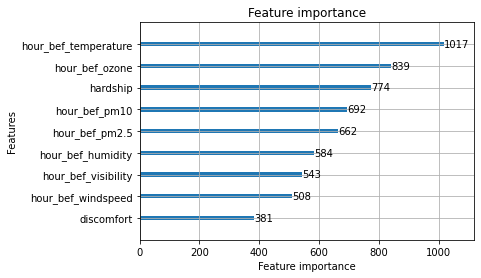

In [47]:
lgbm.plot_importance(lgbm_reg)

## 하이퍼파라미터 튜닝 - optuna

In [18]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.7 MB/s 
     |████████████████████████████████| 209 kB 64.7 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 112 kB 71.1 MB/s 
     |████████████████████████████████| 147 kB 58.9 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=52a8fb8cc499f8d3a53dd11ec9d7884f40b22931c9fe549179b95b6ace3d3a46
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [19]:
# Optuna Libraries
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [48]:
# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    lgbm_param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'mse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    # Generate model
    model_lgbm = LGBMRegressor(**lgbm_param)
    model_lgbm = model_lgbm.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                           verbose=0, early_stopping_rounds=25)
                           
    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하기                        
    MSE = mean_squared_error(val_y, model_lgbm.predict(val_x))
    return MSE

optuna_lgbm = optuna.create_study(direction='minimize', sampler=sampler)

# * n_trials의 경우 optuna를 몇번 실행하여 hyper parameter를 찾을 것인지를 정한다.
# 50으로 설정해도 유의미한 값이 나온다.
optuna_lgbm.optimize(objective, n_trials=100)

[I 2022-11-15 07:24:32,675] A new study created in memory with name: no-name-cb508a82-b7e7-4a11-aa56-d2f8de7c00a3
[I 2022-11-15 07:24:32,918] Trial 0 finished with value: 7077.415477502956 and parameters: {'num_leaves': 230, 'colsample_bytree': 0.7062255848078204, 'reg_alpha': 0.6336482349262754, 'reg_lambda': 7.488038825386118, 'max_depth': 9, 'learning_rate': 2.2324403996622945e-07, 'n_estimators': 674, 'min_child_samples': 78, 'subsample': 0.46704202331689854}. Best is trial 0 with value: 7077.415477502956.
[I 2022-11-15 07:24:33,276] Trial 1 finished with value: 3876.6272338543085 and parameters: {'num_leaves': 3, 'colsample_bytree': 0.9056079455103392, 'reg_alpha': 0.9533933461949365, 'reg_lambda': 0.039482663279144514, 'max_depth': 9, 'learning_rate': 0.0007511484404875245, 'n_estimators': 1876, 'min_child_samples': 74, 'subsample': 0.5226478358414336}. Best is trial 1 with value: 3876.6272338543085.
[I 2022-11-15 07:24:34,281] Trial 2 finished with value: 6154.935532427598 and p

In [49]:
lgbm_trial = optuna_lgbm.best_trial
lgbm_trial_params = lgbm_trial.params
print('Best Trial: score {},\nparams {}'.format(lgbm_trial.value, lgbm_trial_params))

Best Trial: score 2537.1188212549223,
params {'num_leaves': 53, 'colsample_bytree': 0.7206390224716763, 'reg_alpha': 0.901073693427417, 'reg_lambda': 6.36697767336949, 'max_depth': 15, 'learning_rate': 0.008165373834107774, 'n_estimators': 1310, 'min_child_samples': 6, 'subsample': 0.7741197890879554}


In [50]:
# Modeling fit
lgbm_regop = LGBMRegressor(**lgbm_trial_params)
lgbm_study = lgbm_regop.fit(train_x, train_y)

pred_op = lgbm_regop.predict(val_x)
mse= mean_squared_error(val_y,pred_op)
rmse= mse**(1/2)

print("RMSE : ", rmse)

RMSE :  50.23451324402675


In [51]:
Model(lgbm_regop)

Testing Score
 0.6434839817714586


# 제출

In [52]:
# Scaling 과정
transform_tests = test.drop(columns=['id','hour']) 
std_transform_tests = scaler.transform(transform_tests)
test[transform_tests.columns] = std_transform_tests
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,discomfort,hardship
0,0,7,0.760938,-0.180430,-0.858395,0.480048,-0.774579,0.097487,-0.428053,-0.235870,0.693429,-0.868930
1,1,17,2.537863,-0.180430,2.126606,-0.945053,0.317207,1.150800,-0.265527,0.402168,-0.259476,1.742028
2,2,13,0.436124,5.542327,-0.275956,2.101715,-2.080945,-1.008492,-0.688095,-0.164977,2.463110,-1.165683
3,4,6,1.104859,-0.180430,0.015264,0.381765,-0.378034,-0.639833,-0.168011,0.543955,0.693429,-0.256764
4,5,22,-0.404572,5.542327,0.670508,2.003432,-2.038029,0.097487,-1.273189,-1.086589,2.054722,-1.046293


In [54]:
pred= lgbm_regop.predict(test.drop(['id','hour','hour_bef_precipitation'],axis=1))

In [55]:
submission=pd.read_csv('submission.csv')
submission['count'] = pred

In [56]:
submission.to_csv('submission_bike_feature.csv',index=False)

# 04.결론

1. 22.11.10 제출 스코어 : 84.2825
- 사용모델: LGBMRegressor
- 전처리 : standard scaling
- 하이퍼파라미터 튜닝 x

2. 22.11.14 제출 스코어 : 83.37252
- 사용모델 : LGBMRegressor
- 전처리  : Standard scaling
- 하이퍼파라미터 튜닝 : optuna

3. 22.11.15 제출 스코어 : 82.36148
- 사용모델: LGBMRegressor
- 전처리: feature engineering, standard scaling
- 하이퍼파라미터 튜닝 : optuna

stacking 해보기